In [8]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import Omniglot
from torchvision import datasets
from torchvision.models import alexnet, resnet18, resnet34
from tqdm import tqdm
import numpy as np
import time, json

from easyfsl.samplers import TaskSampler
from easyfsl.utils import plot_images, sliding_average
from torch.nn.utils import parameters_to_vector as p2v

In [2]:
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

def show_image(image_numpy_arr):
    fig, ax = plt.subplots()

    # convert the shape from (3, 256, 256) to (256, 256, 3)
    image = image_numpy_arr.transpose(1, 2, 0)

    ax.imshow(image)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
image_size = 224
train_transforms = transforms.Compose([transforms.RandomRotation(30), #data augumnetation
                                       transforms.CenterCrop(image_size),#resize
                                       #transforms.RandomResizedCrop(IMAGE_SIZE),
                                       transforms.RandomHorizontalFlip(), #data augumnetation
                                       transforms.ToTensor()])

val_transforms = transforms.Compose([transforms.RandomRotation(30),
                                     transforms.CenterCrop(image_size), #resize
                                     #transforms.RandomResizedCrop(IMAGE_SIZE),
                                     transforms.RandomHorizontalFlip(), #data augumnetation
                                     transforms.ToTensor()])

test_transforms = transforms.Compose([transforms.RandomRotation(30),
                                     transforms.CenterCrop(image_size), #resize
                                     #transforms.RandomResizedCrop(IMAGE_SIZE),
                                     transforms.RandomHorizontalFlip(), #data augumnetation
                                     transforms.ToTensor()])

traintest_transforms = transforms.Compose([transforms.RandomRotation(30),
                                     transforms.CenterCrop(image_size), #resize
                                     #transforms.RandomResizedCrop(IMAGE_SIZE),
                                     transforms.RandomHorizontalFlip(), #data augumnetation
                                     transforms.ToTensor()])

#train_set = datasets.ImageFolder('../dataset/train', transform=train_transforms)
#val_set = datasets.ImageFolder('../dataset/val', transform=val_transforms)
#test_set = datasets.ImageFolder('../dataset/test_all', transform=test_transforms)

train_set = datasets.ImageFolder('./data/train', transform=train_transforms)
val_set = datasets.ImageFolder('./data/val', transform=val_transforms)
test_set = datasets.ImageFolder('./data/test', transform=test_transforms)
#train_test_set = datasets.ImageFolder('./data/train_test', transform=traintest_transforms)


train_set.idx_to_class = {v:k for k, v in train_set.class_to_idx.items()}
val_set.idx_to_class = {v:k for k, v in val_set.class_to_idx.items()}
test_set.idx_to_class = {v:k for k, v in test_set.class_to_idx.items()}
#train_test_set.idx_to_class = {v:k for k, v in train_test_set.class_to_idx.items()}
"""
"""

'\n'

In [5]:
image_size = 224
train_transforms = transforms.Compose([transforms.RandomRotation(30), #data augumnetation
                                       transforms.CenterCrop(image_size),#resize
                                       #transforms.RandomResizedCrop(IMAGE_SIZE),
                                       transforms.RandomHorizontalFlip(), #data augumnetation
                                       transforms.ToTensor()])

val_transforms = transforms.Compose([transforms.RandomRotation(30),
                                     transforms.CenterCrop(image_size), #resize
                                     #transforms.RandomResizedCrop(IMAGE_SIZE),
                                     transforms.RandomHorizontalFlip(), #data augumnetation
                                     transforms.ToTensor()])

test_transforms = transforms.Compose([transforms.RandomRotation(30),
                                     transforms.CenterCrop(image_size), #resize
                                     #transforms.RandomResizedCrop(IMAGE_SIZE),
                                     transforms.RandomHorizontalFlip(), #data augumnetation
                                     transforms.ToTensor()])

traintest_transforms = transforms.Compose([transforms.RandomRotation(30),
                                     transforms.CenterCrop(image_size), #resize
                                     #transforms.RandomResizedCrop(IMAGE_SIZE),
                                     transforms.RandomHorizontalFlip(), #data augumnetation
                                     transforms.ToTensor()])

#train_set = datasets.ImageFolder('../dataset/train', transform=train_transforms)
#val_set = datasets.ImageFolder('../dataset/val', transform=val_transforms)
#test_set = datasets.ImageFolder('../dataset/test_all', transform=test_transforms)

train_set = datasets.ImageFolder('../dataset/train', transform=train_transforms)
val_set = datasets.ImageFolder('../dataset/val', transform=val_transforms)
test_set = datasets.ImageFolder('../dataset/val', transform=test_transforms)
#train_test_set = datasets.ImageFolder('./data/train_test', transform=traintest_transforms)


train_set.idx_to_class = {v:k for k, v in train_set.class_to_idx.items()}
val_set.idx_to_class = {v:k for k, v in val_set.class_to_idx.items()}
test_set.idx_to_class = {v:k for k, v in test_set.class_to_idx.items()}
#train_test_set.idx_to_class = {v:k for k, v in train_test_set.class_to_idx.items()}
"""
"""

'\n'

In [6]:
len(train_set.classes)

10

In [16]:
class CropDetectCNN3(nn.Module):
    # initialize the class and the parameters
    def __init__(self, inp_size: int, num_classes: int):
        super(CropDetectCNN3, self).__init__()
        # convolutional layer 1 & max pool layer 1
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, padding=1, stride=4),
            #nn.BatchNorm2d(64, momentum=0.05, affine=True),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3)
        )

        O = int(int((inp_size - 11 + 2*1)/4) + 1)
        O = int(O/3)

        self.layer2_0 = nn.Sequential(
            #nn.BatchNorm2d(64, momentum=0.05, affine=True),
            nn.Conv2d(64, 175, kernel_size=7, padding=2, stride=1),
            nn.ReLU(inplace=True),
            #nn.BatchNorm2d(64, momentum=0.05, affine=True),
            nn.Conv2d(175, 343, kernel_size=3, padding=1, stride=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(343, 128, kernel_size=3, padding=1, stride=1),
        )
        
        self.layer2_1 = nn.Sequential(
            #nn.BatchNorm2d(64, momentum=0.05, affine=True),
            nn.Conv2d(64, 180, kernel_size=5, padding=2, stride=1),
            nn.ReLU(inplace=True),
            #nn.BatchNorm2d(64, momentum=0.05, affine=True),
            nn.Conv2d(180, 256, kernel_size=3, padding=1, stride=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, kernel_size=7, padding=2, stride=1),
        )

        O = int((O - 7 + 2*2)/1 + 1)
        #O = int((O - 3 + 2*1)/1 + 1)
        #print("after serial: ", O)

        # convolutional layer 2 & max pool layer 2
        self.layer3 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, kernel_size=5, padding=2, stride=1),
        )

        O = int(O/2)
        print(O)
        #print("after layer3: ", O)

        #Fully connected layer
        self.fc = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128*O*O, 2048),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(2048, num_classes)
        )
        self.inp_size = inp_size
        self.out_size = O

         

    # Feed forward the network
    def forward(self, x):
        #xin = x
        out = self.layer1(x)
        
        future_out1 = torch.jit.fork(self.layer2_0.forward, out)
        future_out = torch.jit.fork(self.layer2_1.forward, out)

        out1 = torch.jit.wait(future_out1)
        out = torch.jit.wait(future_out)
        #print(out.shape)
        out = torch.cat([out1, out], 1)
        out = self.layer3(out)
        #print(out.shape)
        out = out.reshape(out.size(0), -1)
        #print(out.shape)
        #raise
        
        out = self.fc(out)
        return out

OptimisedModel = CropDetectCNN3(image_size, len(train_set.class_to_idx))

8


In [7]:
class PrototypicalNetwork(nn.Module):
    def __init__(self, backbone: nn.Module):
        super(PrototypicalNetwork, self).__init__()
        self.backbone = backbone
        self.out_features = list(self.backbone.modules())[-1].out_features

        self.cls_head = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(self.out_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Dropout(p=0.5),
            nn.Linear(512, 64),
            nn.BatchNorm1d(64),
            nn.Sigmoid(),
            nn.Dropout(p=0.5),

            nn.Linear(64, 1),
        )

    def calc_coords(
        self,
        support_images: torch.Tensor,
        support_labels: torch.Tensor
    ):
        z_support = self.backbone.forward(support_images)
        n_way = len(torch.unique(support_labels)) # num of classes in support set
        z_proto_pre = [z_support[torch.nonzero(support_labels == label)].mean(0) for label in range(n_way)]
        z_proto = torch.cat(z_proto_pre) # Coordinates of all labels on the MAP

        return z_proto, torch.unique(support_labels)

    def one_eval(
        self,
        z_proto: torch.Tensor,
        query_images: torch.Tensor
    ) -> torch.Tensor:
        z_query = self.backbone.forward(query_images)
        #dist = torch.cdist(z_query, z_proto)
        pseudo_similarity = z_query * z_proto

        out = self.cls_head(pseudo_similarity)
        out = out.reshape((out.shape[1], out.shape[0]))

        #print(f"{z_proto.shape=} | {query_images.shape=} | {z_query.shape=} | {pseudo_similarity.shape=} | {out.shape=} | {dist.shape=}")
        #print("z_query * z_proto.... outt shape was switched")
        #raise

        #scores = -dist
        return out
    
    def forward(
        self,
        support_images: torch.Tensor,
        support_labels: torch.Tensor,
        query_images: torch.Tensor,
    ) -> torch.Tensor:
        future_z_support = torch.jit.fork(self.backbone.forward, support_images)
        future_z_query = torch.jit.fork(self.backbone.forward, query_images)

        z_support = torch.jit.wait(future_z_support)
        z_query = torch.jit.wait(future_z_query)

        n_way = len(torch.unique(support_labels)) # num of classes in support set
        z_proto_pre = [z_support[torch.nonzero(support_labels == label)].mean(0) for label in range(n_way)]
        z_proto = torch.cat(z_proto_pre) # Coordinates of all labels on the MAP
        
        #dist = torch.cdist(z_query, z_proto)
        #print(f"{support_images.shape=} | {n_way=} | {z_proto.shape=} | {query_images.shape=} | {z_query.shape=} | {dist.shape=}")
        #print("------")
        #print(f"{z_query.size()=} * {z_proto.size()=}")

        #z_query_proto_pre = [z_query[torch.nonzero(query_labels == label)].mean(0) for label in range(n_way)]
        #z_query_proto = torch.cat(z_query_proto_pre) # Coordinates of all labels on the MAP

        z_proto = z_proto.unsqueeze(0)
        z_query = z_query.unsqueeze(1)
        pseudo_similarity = z_query * z_proto
        #print(f"{pseudo_similarity.shape=}")
        #raise
        out = self.cls_head(pseudo_similarity.view(-1, pseudo_similarity.shape[2]))
        out = out.view(pseudo_similarity.shape[0], pseudo_similarity.shape[1])

        #print(f"{out.shape=} | {dist.shape=}")
        #raise
        #scores = -dist
        return out

        """
        print(f"{n_way=}\n{support_labels=} {support_labels.shape=}\n{z_query=} {z_query.shape=}\n{z_proto=} {z_proto.shape=}\n{dist=} {dist.shape=}")
        print("----------------------")
        label = 0
        print(support_labels == label)
        print(torch.nonzero(support_labels == label))
        print(z_support[torch.nonzero(support_labels == label)], z_support[torch.nonzero(support_labels == label)].shape)
        print(z_support[torch.nonzero(support_labels == label)].mean(0), z_support[torch.nonzero(support_labels == label)].mean(0).shape)
        raise
        """

In [9]:
#cnn = alexnet(pretrained=True)
cnn = alexnet(pretrained=False)
(cnn.classifier._modules)['6'] = nn.Linear(4096, 10)
cnn.load_state_dict(torch.load("../alexnet.torch", weights_only=True))


cnn.classifier[6] = nn.Linear(4096, 1000)

C:\Users\skand\Desktop\leaf_disease_detection\leaf\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\skand\Desktop\leaf_disease_detection\leaf\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<All keys matched successfully>

In [17]:
cnn = OptimisedModel
cnn.load_state_dict(torch.load("../modelv6.torch", weights_only=True))

cnn.fc[5] = nn.Linear(2048, 1000)

In [12]:
#cnn = alexnet(pretrained=True)
cnn = resnet18(pretrained=False)
cnn.fc = nn.Linear(512, 10)
cnn.load_state_dict(torch.load("../resnet18.torch", weights_only=True))


cnn.fc = nn.Linear(512, 1000)

In [13]:
model = PrototypicalNetwork(cnn.to(device)).to(device)

In [21]:
model.load_state_dict(torch.load("oneshot-alexnet-custom.pt", weights_only=True))

<All keys matched successfully>

In [14]:
#N_WAY = 5 # no of class per task
N_WAY = len(test_set.classes)
#N_SHOT = 5 # no of images per class in support set
N_SHOT = 3
N_QUERY = 8 # no of images per class in query set
#N_EVALUATION_TASKS = 1
N_EVALUATION_TASKS = len(test_set)

def get_labels():
    return test_set.targets
    
test_set.get_labels = get_labels

test_sampler = TaskSampler(
    test_set,
    n_way=N_WAY,
    n_shot=N_SHOT,
    n_query=N_QUERY,
    n_tasks=N_EVALUATION_TASKS,
)

test_loader = DataLoader(
    test_set,
    batch_sampler=test_sampler,
    collate_fn=test_sampler.episodic_collate_fn
)

torch.Size([30, 3, 224, 224])

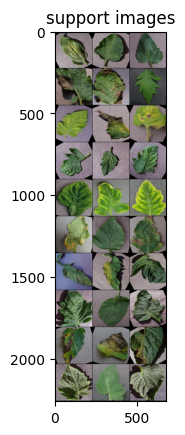

In [15]:
(example_support_images, example_support_labels, example_query_images, example_query_labels, example_num_of_class) = next(iter(test_loader))
#(example_support_images, example_support_labels) = next(iter(test_loader))
plot_images(example_support_images, "support images", images_per_row=N_SHOT)

example_support_images.shape

In [16]:
#N_WAY = 5 # no of class per task
TR_N_WAY = len(train_set.classes)
#N_SHOT = 5 # no of images per class in support set
TR_N_QUERY = 4 # no of images per class in query set
#N_EVALUATION_TASKS = 1
TR_N_EVALUATION_TASKS = len(train_set)

def get_labels():
    return train_set.targets
    
train_set.get_labels = get_labels

train_sampler = TaskSampler(
    train_set,
    n_way=TR_N_WAY,
    n_shot=N_SHOT,
    n_query=TR_N_QUERY,
    n_tasks=TR_N_EVALUATION_TASKS,
)

train_loader = DataLoader(
    train_set,
    batch_sampler=train_sampler,
    collate_fn=train_sampler.episodic_collate_fn
)

In [17]:
#N_WAY = 5 # no of class per task
VAL_N_WAY = len(val_set.classes)
#N_SHOT = 5 # no of images per class in support set
VAL_N_QUERY = 8 # no of images per class in query set
#N_EVALUATION_TASKS = 1
VAL_N_EVALUATION_TASKS = len(val_set)

def get_labels():
    return val_set.targets
    
val_set.get_labels = get_labels

val_sampler = TaskSampler(
    val_set,
    n_way=VAL_N_WAY,
    n_shot=N_SHOT,
    n_query=VAL_N_QUERY,
    n_tasks=VAL_N_EVALUATION_TASKS,
)

val_loader = DataLoader(
    val_set,
    batch_sampler=val_sampler,
    collate_fn=val_sampler.episodic_collate_fn
)

In [18]:
criterion = nn.BCEWithLogitsLoss()
#criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [19]:
epochs = 1 # run more iterations
valid_accuracy_track = []
start_time = time.time()

for epoch in range(epochs):
    running_loss = 0
    model.train()
    for (
        support_images,
        support_labels,
        query_images,
        query_labels,
        _
    ) in tqdm(train_loader, desc=f"Epoch: {epoch+1}| Training: "):
    #) in tqdm(val_loader, desc=f"Epoch: {epoch+1}| Training: "):
        # To device - to transfrom the image and classes to CPU|GPU
        (support_images,
        support_labels,
        query_images) = (
            support_images.to(device),
            support_labels.to(device),
            query_images.to(device),
        )
        
        # clears old gradients from the last step
        optimizer.zero_grad()

        # train the images
        outputs = model(support_images, support_labels, query_images)

        #calculate the loss given the outputs and the classes
        loss = criterion(outputs, torch.nn.functional.one_hot(query_labels).type(torch.FloatTensor).to(device))
        #loss = criterion(outputs, query_labels.to(device))
        #print(torch.exp(outputs).topk(1, dim=1)[1], "-----------", query_labels, "-----------", loss)
        #raise

        # compute the loss of every parameter
        loss.backward()

        # apply the optimizer and its parameters
        optimizer.step()

        #update the loss
        running_loss += loss.item()
    else: # doesnt run if i break out of loop
        validation_loss = 0
        accuracy = 0
        
        # to make the model run faster we are using the gradients on the train
        with torch.no_grad():
            # specify that this is validation and not training
            model.eval()
            for (
                support_images,
                support_labels,
                query_images,
                query_labels,
                _
            ) in tqdm(val_loader, desc=f"Epoch: {epoch+1}| Validation: "):
                # Use GPU
                (support_images,
                support_labels,
                query_images,
                query_labels) = (
                    support_images.to(device),
                    support_labels.to(device),
                    query_images.to(device),
                    query_labels.to(device)
                )
                
                # validate the images
                outputs = model(support_images, support_labels, query_images)

                # compute validation loss
                loss = criterion(outputs, torch.nn.functional.one_hot(query_labels).type(torch.FloatTensor).to(device))
                #loss = criterion(outputs, query_labels)

                #update loss
                validation_loss += loss.item()

                # get the exponential of the outputs
                ps = torch.exp(outputs)

                #Returns the k largest elements of the given input tensor along a given dimension.
                top_p, top_class = ps.topk(1, dim=1)

                # reshape the tensor
                equals = top_class == query_labels.view(*top_class.shape)

                # calculate the accuracy.
                accuracy += torch.mean(equals.type(torch.FloatTensor))

        # change the mode to train for the next epochs

        print("Epoch: {}/{}.. ".format(epoch+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(train_loader)),
              "Valid Loss: {:.3f}.. ".format(validation_loss/len(val_loader)),
              "Valid Accuracy: {:.3f}".format(accuracy/len(val_loader))
             )
        valid_accuracy_track.append((accuracy/len(val_loader)).item())

end_time = time.time()

elapsed = end_time - start_time

Epoch: 1| Training: 100%|██████████████████████████████████████████████████████| 17696/17696 [2:04:40<00:00,  2.37it/s]
Epoch: 1| Validation: 100%|████████████████████████████████████████████████████████| 4585/4585 [24:15<00:00,  3.15it/s]

Epoch: 1/1..  Training Loss: 0.038..  Valid Loss: 0.055..  Valid Accuracy: 0.966


In [20]:
with open("stats.json", "r") as file:
    stats = json.loads(file.read())

stats["valid_accuracy"]["resnet18"] = valid_accuracy_track
stats["time_taken"]["resnet18"] = elapsed
stats["params"]["resnet18"] = p2v(model.parameters()).numel()

with open("stats.json", "w") as file:
    file.write(json.dumps(stats))

In [21]:
torch.save(model.state_dict(), "oneshot-resnet18.pt")

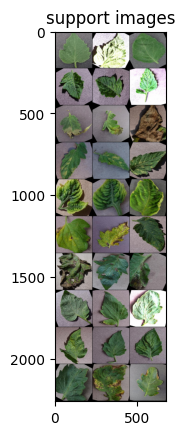

In [22]:
support_coords = None
def calc_support_coords(loader:None|DataLoader=None, show=False):
    if loader is None:
        loader = DataLoader(
            test_set,
            batch_sampler=test_sampler,
            collate_fn=test_sampler.episodic_collate_fn
        )
    (support_images, support_labels, _, _, _) = next(iter(loader))
    if show: plot_images(support_images, "support images", images_per_row=N_SHOT)
    return model.calc_coords(support_images.cuda(), support_labels.cuda())

support_coords, support_labels = calc_support_coords(test_loader, True)

In [23]:
def process_image(image_path):
    test_transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.RandomRotation(30),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(image_size),
        transforms.ToTensor()]
    )
    image_path = Image.open(image_path)
    image_path = test_transform(image_path)
    return image_path

def predict(image: str, model: nn.Module, support_coords: torch.Tensor, set_, show: bool=False) -> tuple[float, list[str]]:
    if support_coords is None: raise

    model.eval()
    image = process_image(image)
    image_inp = image.unsqueeze(0)

    with torch.no_grad():

        output = model.one_eval( 
                support_coords.cuda(),
                image_inp.cuda()
            ).detach().data

    #ps = torch.nn.functional.softmax(output, dim=1)
    ps = torch.nn.functional.sigmoid(output)
    #print("OUTPUT DETS: ", output, output.shape)
    top_p, top_cls_i = ps.topk(5, dim=1)
    top_p, top_cls_i = top_p[0].detach().cpu(), top_cls_i[0].detach().cpu()

    #top_cls = [test_set.idx_to_class[int(support_labels[top_class])] for top_class in top_cls_i]
    top_cls = [set_.idx_to_class[int(top_class)] for top_class in top_cls_i]
    
    if show:
        show_image(np.array(image_inp[0]))
        plt.figure(figsize = (6,10))
        plt.subplot(2,1,2)
        sns.barplot(x=top_p, y=top_cls, color=sns.color_palette()[2]);
        plt.show()
    return top_p, top_cls

In [24]:
import os

accuracy = total = 0

true_list = []
pred = []

#for i, (root, dirs, files) in enumerate(os.walk("../dataset/train")):
for i, (root, dirs, files) in enumerate(os.walk("../dataset/val")):
    if i % 10 == 0:
        #support_coords, support_labels = calc_support_coords(train_loader)
        #support_coords, support_labels = calc_support_coords(val_loader)
        support_coords, support_labels = calc_support_coords(test_loader)

    if len(files) == 0:
        continue

    folder = root.split("\\")[-1]

    fol_acc = fol_tot = 0
    
    for file in files:
        #image = f"../dataset/train/{folder}/{file}"
        image = f"../dataset/val/{folder}/{file}"
        
        #ps, classes = predict(image, model, support_coords, train_set, False)
        #ps, classes = predict(image, model, support_coords, val_set, False)
        ps, classes = predict(image, model, support_coords, test_set, False)
        if classes[0] == folder:
            accuracy += 1
            fol_acc += 1

        true_list.append(folder)
        pred.append(classes[0])
        total += 1
        fol_tot += 1

    print(f"{folder}: {fol_acc}/{fol_tot} OR {fol_acc/fol_tot :.2f}")

print("\n")
print(f"FINAL: {accuracy}/{total} OR {accuracy/total :.2f}")

Tomato___Bacterial_spot: 422/425 OR 0.99
Tomato___Early_blight: 480/480 OR 1.00
Tomato___healthy: 437/481 OR 0.91
Tomato___Late_blight: 442/463 OR 0.95
Tomato___Leaf_Mold: 469/470 OR 1.00
Tomato___Septoria_leaf_spot: 416/436 OR 0.95
Tomato___Spider_mites Two-spotted_spider_mite: 429/435 OR 0.99
Tomato___Target_Spot: 399/457 OR 0.87
Tomato___Tomato_mosaic_virus: 374/448 OR 0.83
Tomato___Tomato_Yellow_Leaf_Curl_Virus: 488/490 OR 1.00


FINAL: 4356/4585 OR 0.95


In [25]:
with open("stats.json", "r") as file:
    stats = json.loads(file.read())

stats["final_accuracy"]["resnet18"] = accuracy/total

with open("stats.json", "w") as file:
    file.write(json.dumps(stats))

[Text(0.5, 23.38159722222222, 'Pred'), Text(77.78159722222226, 0.5, 'Truth')]

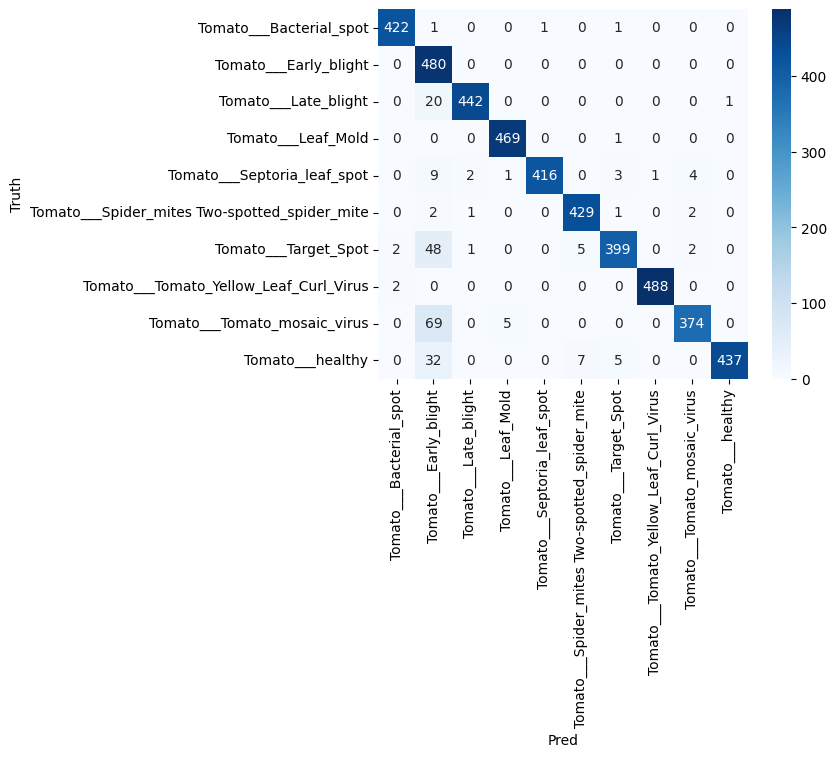

In [26]:
from sklearn.metrics import confusion_matrix

classes_list = list(sorted(test_set.class_to_idx.keys()))

matrix_confusion = confusion_matrix(true_list, pred, labels=classes_list)

#classes_list = [i[10:] for i in classes_list]
ax = sns.heatmap(matrix_confusion, square=True, annot=True, cmap='Blues', fmt='d', xticklabels=classes_list, yticklabels=classes_list)
#sns.heatmap(glue, annot=True)
ax.set(xlabel="Pred", ylabel="Truth")

In [27]:
import torchmetrics
pred_tensor, truth_tensor = torch.Tensor([test_set.class_to_idx[i] for i in pred]), torch.Tensor([test_set.class_to_idx[i] for i in true_list])

acc = torchmetrics.functional.accuracy(pred_tensor, truth_tensor, average="macro", task="multiclass", num_classes=len(classes_list))
precision = torchmetrics.functional.precision(pred_tensor, truth_tensor, average="macro", task="multiclass", num_classes=len(classes_list))
recall = torchmetrics.functional.recall(pred_tensor, truth_tensor, average="macro", task="multiclass", num_classes=len(classes_list))
f1 = torchmetrics.functional.f1_score(pred_tensor, truth_tensor, average="macro", task="multiclass", num_classes=len(classes_list))

(acc, precision, recall, f1)

(tensor(0.9498), tensor(0.9613), tensor(0.9498), tensor(0.9523))

In [28]:
with open("stats.json", "r") as file:
    stats = json.loads(file.read())

stats["confusion_matrix"]["resnet18"] = np.array(matrix_confusion).tolist()
stats["metrics"]["accuracy"]["resnet18"] = float(acc)
stats["metrics"]["precision"]["resnet18"] = float(precision)
stats["metrics"]["recall"]["resnet18"] = float(recall)
stats["metrics"]["f1_score"]["resnet18"] = float(f1)


with open("stats.json", "w") as file:
    file.write(json.dumps(stats))